In [33]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.datasets import load_sample_image

In [34]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [35]:
print(f"dataset_size = {dataset_size}")
print(f"class_names = {class_names}")
print(f"n_classes = {n_classes}")

dataset_size = 3670
class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
n_classes = 5


In [36]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [37]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

2023-03-14 21:06:56.706205: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


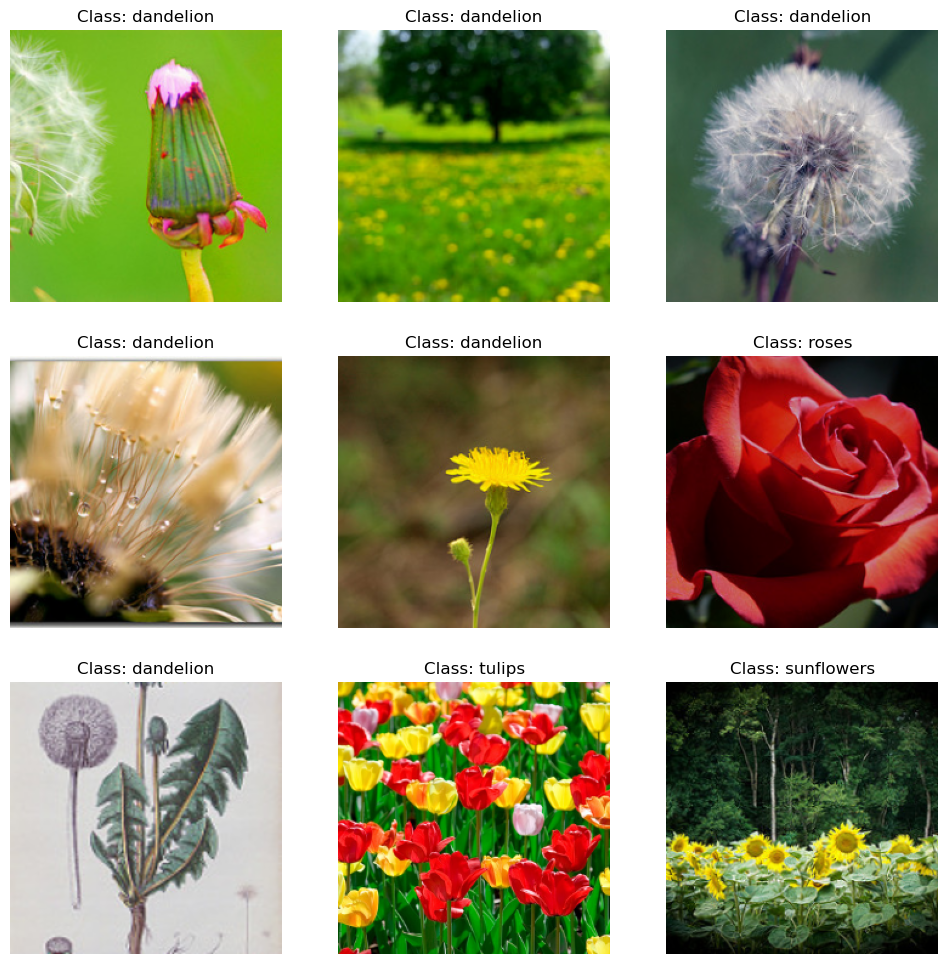

In [38]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

## Create the Model

In [39]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [40]:
for layer in base_model.layers:
    layer.trainable = False

## Compile the Model

In [41]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.1)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, 
              metrics=["accuracy"])

## Train the model

In [42]:
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 115s 1s/step - loss: 0.6619 - accuracy: 0.8310 - val_loss: 0.6295 - val_accuracy: 0.8457
Epoch 2/5
86/86 [==============================] - 141s 2s/step - loss: 0.2747 - accuracy: 0.9146 - val_loss: 0.5368 - val_accuracy: 0.8439
Epoch 3/5
86/86 [==============================] - 1354s 16s/step - loss: 0.1978 - accuracy: 0.9375 - val_loss: 0.5010 - val_accuracy: 0.8621
Epoch 4/5
86/86 [==============================] - 111s 1s/step - loss: 0.1658 - accuracy: 0.9520 - val_loss: 0.4836 - val_accuracy: 0.8693
Epoch 5/5
86/86 [==============================] - 285s 3s/step - loss: 0.1516 - accuracy: 0.9568 - val_loss: 0.4899 - val_accuracy: 0.8675


In [43]:
for layer in base_model.layers:
    layer.trainable = True

In [44]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer, 
              metrics=["accuracy"])

In [45]:
history = model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10
86/86 [==============================] - 545s 6s/step - loss: 0.3068 - accuracy: 0.8939 - val_loss: 0.6626 - val_accuracy: 0.8149
Epoch 2/10
86/86 [==============================] - 419s 5s/step - loss: 0.0535 - accuracy: 0.9858 - val_loss: 0.2667 - val_accuracy: 0.9220
Epoch 3/10
86/86 [==============================] - 413s 5s/step - loss: 0.0176 - accuracy: 0.9942 - val_loss: 0.2444 - val_accuracy: 0.9201
Epoch 4/10
86/86 [==============================] - 414s 5s/step - loss: 0.0098 - accuracy: 0.9978 - val_loss: 0.2736 - val_accuracy: 0.9220
Epoch 5/10
86/86 [==============================] - 416s 5s/step - loss: 0.0119 - accuracy: 0.9964 - val_loss: 0.2981 - val_accuracy: 0.9183
Epoch 6/10
86/86 [==============================] - 410s 5s/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.2899 - val_accuracy: 0.9147
Epoch 7/10
86/86 [==============================] - 419s 5s/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.2811 - val_accuracy: 0.9220
Epoch 8/10
86

## Object Detection

In [46]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)

In [47]:
model = keras.Model(inputs=base_model.input, 
                    outputs=[class_output, loc_output])

In [48]:
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer,
              metrics=["accuracy"])

In [51]:
# extra code – fits the model using random target bounding boxes (in real life
#              you would need to create proper targets instead)

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 [==============================] - 52s 5s/step - loss: 0.1659 - dense_1_loss: 0.1742 - dense_2_loss: 0.1329 - dense_1_accuracy: 0.9656 - dense_2_accuracy: 0.2500
Epoch 2/2
10/10 [==============================] - 65s 7s/step - loss: 0.1412 - dense_1_loss: 0.1434 - dense_2_loss: 0.1325 - dense_1_accuracy: 0.9719 - dense_2_accuracy: 0.2937
